# Normalization: From First Principles to Modern Techniques

Why do neural networks need normalization? Why does "zero mean, unit variance" matter?

This notebook builds up the intuition from scratch. Starting with the fundamental problem that normalization solves, through the history of techniques people tried, to the modern methods used in transformers today.


In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

import sys
from pathlib import Path

# Add workspace root to Python path so we can import silen_lib
workspace_root = Path.cwd().parent.parent
if str(workspace_root) not in sys.path:
    sys.path.insert(0, str(workspace_root))

import silen_lib.utils as utils

utils.set_seed(42)


## The Fundamental Problem: Activations Go Wild

Let's start with a simple question: what happens when we stack many layers in a neural network?


In [3]:
# Simulate passing an input through many layers
# Each layer multiplies by a weight matrix

def simulate_forward_pass(input_vector, num_layers, weight_scale=1.0):
    """Pass input through num_layers linear layers (no activation for simplicity)"""
    x = input_vector.copy()
    layer_outputs = [x.copy()]
    
    hidden_size = len(input_vector)
    
    for layer in range(num_layers):
        # Random weight matrix, scaled
        W = np.random.randn(hidden_size, hidden_size) * weight_scale
        x = W @ x
        layer_outputs.append(x.copy())
    
    return layer_outputs

# Start with a simple input
input_vec = np.array([1.0, 0.5, -0.3, 0.8, -0.2])
print("Input:", input_vec)
print(f"Input magnitude: {np.linalg.norm(input_vec):.4f}")


Input: [ 1.   0.5 -0.3  0.8 -0.2]
Input magnitude: 1.4213


In [5]:
# What happens after 10 layers with different weight scales?
scales = [0.5, 1.0, 1.5]
num_layers = 10

print(f"Magnitude of activations after {num_layers} layers:\n")
for scale in scales:
    outputs = simulate_forward_pass(input_vec, num_layers, weight_scale=scale)
    final_magnitude = np.linalg.norm(outputs[-1])
    print(f"Weight scale {scale}: {final_magnitude}")


Magnitude of activations after 10 layers:

Weight scale 0.5: 0.41862494824716334
Weight scale 1.0: 1344.105820093675
Weight scale 1.5: 195276.33360126027


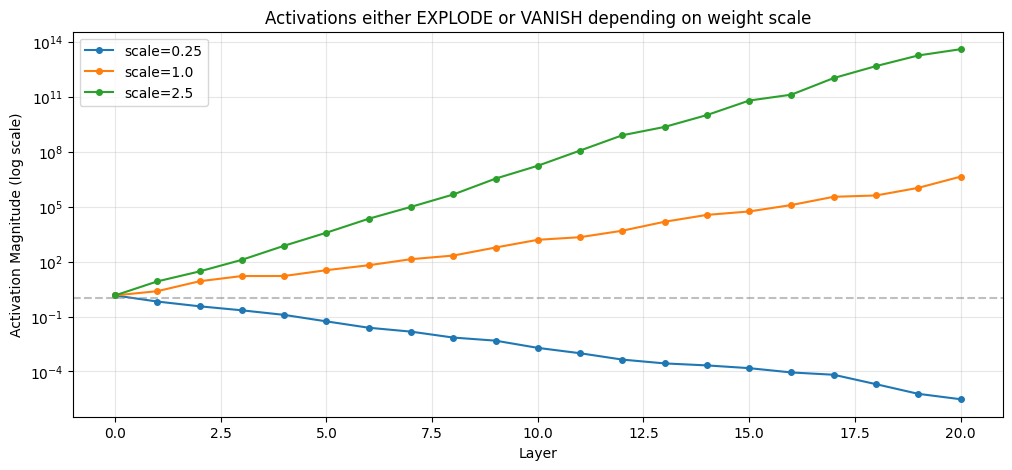

→ Too small weights: activations vanish → gradients vanish → no learning
→ Too large weights: activations explode → gradients explode → unstable training


In [7]:
# Visualize how activation magnitudes evolve layer by layer
fig, ax = plt.subplots(figsize=(12, 5))

for scale in [0.25, 1.0, 2.5]:
    outputs = simulate_forward_pass(input_vec, 20, weight_scale=scale)
    magnitudes = [np.linalg.norm(out) for out in outputs]
    ax.semilogy(range(len(magnitudes)), magnitudes, 'o-', label=f'scale={scale}', markersize=4)

ax.set_xlabel('Layer')
ax.set_ylabel('Activation Magnitude (log scale)')
ax.set_title('Activations either EXPLODE or VANISH depending on weight scale')
ax.legend()
ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5, label='magnitude=1')
ax.grid(True, alpha=0.3)
plt.show()

print("→ Too small weights: activations vanish → gradients vanish → no learning")
print("→ Too large weights: activations explode → gradients explode → unstable training")


**This is the fundamental problem**: In deep networks, small deviations compound exponentially. 

- If weights are slightly too large: activations grow exponentially → overflow, NaN
- If weights are slightly too small: activations shrink exponentially → vanish, no gradient signal

We need activations to stay in a "reasonable" range throughout training. But how?


## First Attempt: Careful Weight Initialization

The first natural idea: what if we simply initialize the weights with exactly the "right" scale?

Why does this matter? Intuitively, we want the activations at each layer to stay in a healthy range. Not exploding to huge values or shrinking to zero. This means, ideally, that the *mean* of the activations stays near zero and the *variance* stays near one as we go through layers.

### Why is "mean 0, variance 1" so important?

**The Surface Reason:**
- If the mean drifts from zero, most activations could saturate (especially with nonlinearities like tanh/sigmoid), killing the gradient.
- If the variance grows (or shrinks) with each layer, the signal becomes exponentially more extreme (or dies out) in deep networks.
- Keeping things centered with unit variance helps gradients stay stable so the network can *learn* effectively at depth.

**The Deeper Reason:**

Think about what happens in a chain of layers. If variance grows by a factor of $\alpha > 1$ per layer:
$$\text{Var}(h^{(L)}) = \alpha^L \cdot \text{Var}(h^{(0)})$$

For a 50-layer network with $\alpha = 1.1$:
$$\text{Var}(h^{(50)}) = 1.1^{50} \approx 117 \times \text{Var}(h^{(0)})$$

This compounds *exponentially*. Even tiny deviations become catastrophic in deep networks!

**Why this breaks gradient flow:**

Remember, gradients flow backward: $\frac{\partial L}{\partial h^{(0)}} = \frac{\partial L}{\partial h^{(L)}} \cdot \prod_{i=0}^{L-1} \frac{\partial h^{(i+1)}}{\partial h^{(i)}}$

If activations explode (large variance), gradients often explode too. If activations vanish (small variance), gradients vanish. The gradient becomes either numerically unstable or effectively zero — making learning impossible.

**Mean = 0 specifically matters because:**
- Many activation functions (tanh, sigmoid) are centered around 0
- Non-zero mean causes systematic bias that accumulates through layers
- For ReLU specifically: if inputs are always positive/negative, ReLU is always on/off → loses half its expressiveness

So: if we carefully pick the weight scale so that each layer preserves variance and mean, activations will neither explode nor vanish. That's the goal!

### The Mathematics: Finding the Right σ

We established that we want activations to maintain **mean 0** and **variance 1** through each layer. Now let's figure out what weight initialization achieves this.

**The Linear Layer:**

Consider a single linear layer: $y = Wx$ where:
- $x \in \mathbb{R}^{n_{\text{in}}}$ is our input (assume already has mean 0, variance 1)
- $W \in \mathbb{R}^{n_{\text{out}} \times n_{\text{in}}}$ is our weight matrix
- $y \in \mathbb{R}^{n_{\text{out}}}$ is our output

We initialize weights from a normal distribution: $W_{ij} \sim \mathcal{N}(0, \sigma^2)$

**The Question:** What value of $\sigma$ preserves variance 1?

**Step 1: Write out the computation**

Each output element is a dot product:
$$y_i = \sum_{j=1}^{n_{\text{in}}} W_{ij} \cdot x_j$$

**Step 2: Compute the output variance**

$$\text{Var}(y_i) = \text{Var}\left(\sum_{j=1}^{n_{\text{in}}} W_{ij} \cdot x_j\right)$$

Since weights and inputs are independent across $j$:
$$= \sum_{j=1}^{n_{\text{in}}} \text{Var}(W_{ij} \cdot x_j)$$

**Step 3: Variance of a product of independent random variables**

We need to find $\text{Var}(W_{ij} \cdot x_j)$.

For independent random variables $A$ and $B$ both with zero mean:
$$\text{Var}(A \cdot B) = \mathbb{E}[A^2] \cdot \mathbb{E}[B^2]$$

(This works because $\mathbb{E}[AB] = \mathbb{E}[A]\mathbb{E}[B] = 0$ when they're independent with zero mean)

And since $\mathbb{E}[A^2] = \text{Var}(A)$ when $\mathbb{E}[A] = 0$:
$$\text{Var}(A \cdot B) = \text{Var}(A) \cdot \text{Var}(B)$$

**Applying to our case:**

Now substitute $A = W_{ij}$ and $B = x_j$:

$$\text{Var}(W_{ij} \cdot x_j) = \text{Var}(W_{ij}) \cdot \text{Var}(x_j)$$

What are these variances?
- $\text{Var}(W_{ij}) = \sigma^2$ — this is how we *defined* our weight initialization: $W_{ij} \sim \mathcal{N}(0, \sigma^2)$
- $\text{Var}(x_j) = 1$ — this is our *assumption* that the input has unit variance

Therefore:
$$\text{Var}(W_{ij} \cdot x_j) = \sigma^2 \cdot 1 = \sigma^2$$

**Step 4: Sum over all inputs**

The output $y_i$ sums over $n_{\text{in}}$ terms, each contributing variance $\sigma^2$:

$$\text{Var}(y_i) = \sum_{j=1}^{n_{\text{in}}} \sigma^2 = \underbrace{\sigma^2 + \sigma^2 + \cdots + \sigma^2}_{n_{\text{in}} \text{ times}} = n_{\text{in}} \cdot \sigma^2$$

**Step 5: Solve for σ**

To preserve unit variance ($\text{Var}(y) = 1$):
$$n_{\text{in}} \cdot \sigma^2 = 1$$
$$\boxed{\sigma = \frac{1}{\sqrt{n_{\text{in}}}}}$$

Even if inputs have variance ≈1, the output of a linear layer sums 𝑛_in independent contributions, so its variance scales like 𝑛_in*𝜎^2. To keep activations from exploding/vanishing across layers, we choose the weight initialization variance 𝜎^2 = 1/𝑛_in.

In [ ]:
# Let's verify this empirically
n_in = 100
n_out = 100
num_trials = 1000

# Random inputs with variance 1
x = np.random.randn(num_trials, n_in)
print(f"Input variance: {x.var():.4f}")

# Try different weight scales
for scale_name, sigma in [("σ=1", 1.0), ("σ=0.1", 0.1), ("σ=1/√n", 1/np.sqrt(n_in))]:
    W = np.random.randn(n_out, n_in) * sigma
    y = x @ W.T
    print(f"Weight scale {scale_name}: output variance = {y.var():.4f}")


Input variance: 0.9968
Weight scale σ=1: output variance = 99.5402
Weight scale σ=0.1: output variance = 1.0288
Weight scale σ=1/√n: output variance = 0.9850


This was the insight behind **Xavier/Glorot initialization** (2010): Initialize weights with $\sigma = \sqrt{\frac{1}{n_{in}}}$

### The Problem: Xavier Assumes Linear Activations

Our derivation above assumed a purely linear layer: $y = Wx$. But real networks have nonlinear activations!

**What happens with ReLU?**

ReLU is defined as: $\text{ReLU}(x) = \max(0, x)$

For inputs centered at 0, roughly half are positive (pass through) and half are negative (become 0). This means:
- **Half the signal is killed** at each layer
- The variance is cut in half: $\text{Var}(\text{ReLU}(x)) \approx \frac{1}{2} \text{Var}(x)$

So with Xavier init + ReLU:
$$\text{Var}(y^{(L)}) \approx \left(\frac{1}{2}\right)^L \cdot \text{Var}(x)$$

After just 10 layers: variance drops to $(1/2)^{10} \approx 0.001$ of the original — the signal vanishes!

**He initialization** (2015) fixes this by doubling the variance to compensate:
$$\sigma = \sqrt{\frac{2}{n_{in}}}$$

The factor of 2 counteracts ReLU zeroing half the values, so variance is preserved through layers.

In [14]:
# Compare Xavier vs He initialization after ReLU in terms of output variance

n_in = 1000
n_out = 1000
num_samples = 10000

# Generate random data centered at 0, variance ≈ 1
x = np.random.randn(num_samples, n_in)
print(f"Input stats:\n  Mean: {x.mean():.4f}\n  Var: {x.var():.4f}")

for name, sigma in [("Xavier (σ=1/√n)", 1/np.sqrt(n_in)), 
                    ("He (σ=√(2/n))", np.sqrt(2/n_in))]:
    W = np.random.randn(n_out, n_in) * sigma
    y = x @ W.T

    print(f"\n{name}:")
    print(f"  Before ReLU → Mean: {y.mean():.4f}, Var: {y.var():.4f}")

    y_relu = np.maximum(0, y)
    relu_var_ratio = y_relu.var() / y.var() if y.var() != 0 else float('nan')
    print(f"  After ReLU → Mean: {y_relu.mean():.4f}, Var: {y_relu.var():.4f}")
    print(f"  Variance/Initial: {y_relu.var()/x.var():.4f},  Post-ReLU/Pre-ReLU: {relu_var_ratio:.4f}")


Input stats:
  Mean: -0.0002
  Var: 1.0001

Xavier (σ=1/√n):
  Before ReLU → Mean: 0.0002, Var: 0.9999
  After ReLU → Mean: 0.3990, Var: 0.3409
  Variance/Initial: 0.3409,  Post-ReLU/Pre-ReLU: 0.3409

He (σ=√(2/n)):
  Before ReLU → Mean: -0.0004, Var: 2.0002
  After ReLU → Mean: 0.5639, Var: 0.6814
  Variance/Initial: 0.6814,  Post-ReLU/Pre-ReLU: 0.3407


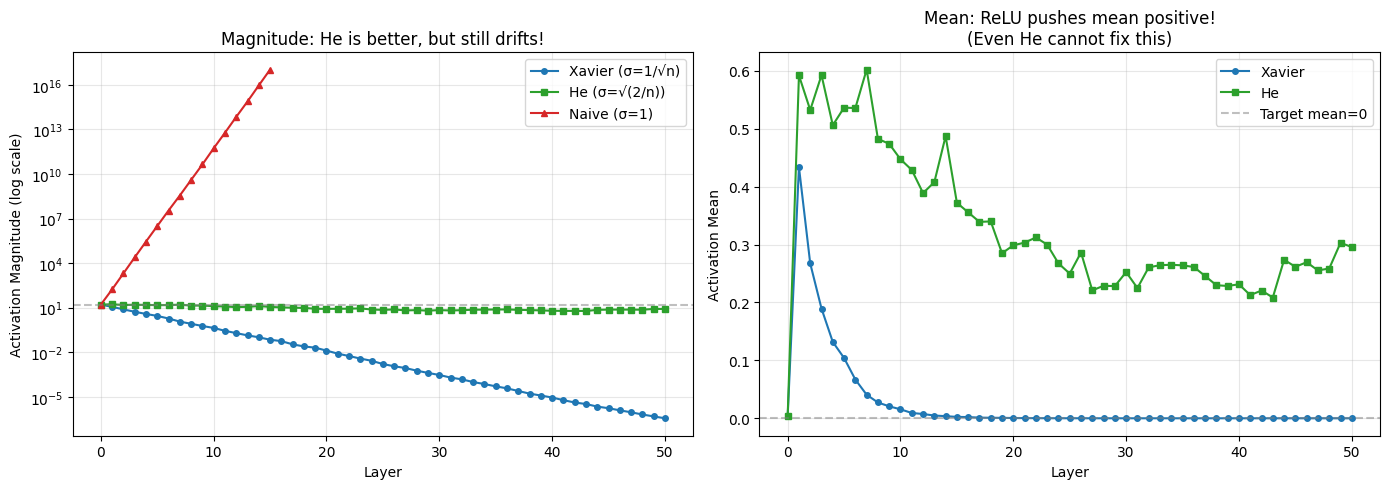


Detailed statistics at key layers:
Layer    Init       Magnitude       Mean            Std            
---------------------------------------------------------------
0        Xavier     1.6160e+01      0.0035          1.0100         
         He         1.6160e+01      0.0035          1.0100         
         Naive      1.6160e+01      0.0035          1.0100         

10       Xavier     4.3411e-01      0.0155          0.0223         
         He         1.2733e+01      0.4473          0.6582         
         Naive      5.3702e+11      19893710347.4699 27032696326.6330

25       Xavier     1.6125e-03      0.0001          0.0001         
         He         7.1473e+00      0.2499          0.3703         

50       Xavier     3.5838e-07      0.0000          0.0000         
         He         8.2563e+00      0.2957          0.4229         

KEY INSIGHT:
→ He init preserves VARIANCE better than Xavier


In [23]:
# Demonstrate: Xavier fails with ReLU, He is better but NOT perfect

def simulate_with_relu_detailed(input_vec, num_layers, init_type='xavier'):
    """Forward pass with ReLU, tracking norm, mean, and std"""
    x = input_vec.copy()
    stats = [{
        'norm': np.linalg.norm(x),
        'mean': x.mean(),
        'std': x.std()
    }]
    hidden_size = len(input_vec)
    
    for layer in range(num_layers):
        if init_type == 'xavier':
            sigma = 1 / np.sqrt(hidden_size)
        elif init_type == 'he':
            sigma = np.sqrt(2 / hidden_size)
        else:  # naive
            sigma = 1.0
            
        W = np.random.randn(hidden_size, hidden_size) * sigma
        x = W @ x
        x = np.maximum(0, x)  # ReLU activation!
        stats.append({
            'norm': np.linalg.norm(x),
            'mean': x.mean(),
            'std': x.std()
        })
    
    return stats

# Use larger hidden size for clearer statistics
hidden_size = 256
input_vec = np.random.randn(hidden_size)
num_layers = 50

# Run simulations (use different seeds to show variability)
stats_xavier = simulate_with_relu_detailed(input_vec.copy(), num_layers, 'xavier')
stats_he = simulate_with_relu_detailed(input_vec.copy(), num_layers, 'he')
stats_naive = simulate_with_relu_detailed(input_vec.copy(), num_layers, 'naive')

# Extract data
norms_xavier = [s['norm'] for s in stats_xavier]
norms_he = [s['norm'] for s in stats_he]
norms_naive = [s['norm'] for s in stats_naive]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

layers = range(num_layers + 1)

# Left: Magnitude
ax = axes[0]
ax.semilogy(layers, norms_xavier, 'o-', label='Xavier (σ=1/√n)', markersize=4, color='tab:blue')
ax.semilogy(layers, norms_he, 's-', label='He (σ=√(2/n))', markersize=4, color='tab:green')
layers_naive = range(min(16, num_layers + 1))
ax.semilogy(layers_naive, norms_naive[:len(layers_naive)], '^-', label='Naive (σ=1)', markersize=4, color='tab:red')
ax.axhline(y=norms_xavier[0], color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Layer')
ax.set_ylabel('Activation Magnitude (log scale)')
ax.set_title('Magnitude: He is better, but still drifts!')
ax.legend()
ax.grid(True, alpha=0.3)

# Right: Mean (should stay near 0 but doesn't with ReLU!)
ax = axes[1]
means_xavier = [s['mean'] for s in stats_xavier]
means_he = [s['mean'] for s in stats_he]
ax.plot(layers, means_xavier, 'o-', label='Xavier', markersize=4, color='tab:blue')
ax.plot(layers, means_he, 's-', label='He', markersize=4, color='tab:green')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Target mean=0')
ax.set_xlabel('Layer')
ax.set_ylabel('Activation Mean')
ax.set_title('Mean: ReLU pushes mean positive!\n(Even He cannot fix this)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed statistics table
print(f"\nDetailed statistics at key layers:")
print(f"{'Layer':<8} {'Init':<10} {'Magnitude':<15} {'Mean':<15} {'Std':<15}")
print("-" * 63)
for layer in [0, 10, 25, 50]:
    print(f"{layer:<8} {'Xavier':<10} {stats_xavier[layer]['norm']:<15.4e} {stats_xavier[layer]['mean']:<15.4f} {stats_xavier[layer]['std']:<15.4f}")
    print(f"{'':<8} {'He':<10} {stats_he[layer]['norm']:<15.4e} {stats_he[layer]['mean']:<15.4f} {stats_he[layer]['std']:<15.4f}")
    if layer <= 15:
        print(f"{'':<8} {'Naive':<10} {stats_naive[layer]['norm']:<15.4e} {stats_naive[layer]['mean']:<15.4f} {stats_naive[layer]['std']:<15.4f}")
    print()

print("KEY INSIGHT:")
print("→ He init preserves VARIANCE better than Xavier")

### The Limitation: Initialization is Only the Beginning

Proper initialization helps at the START of training. But as we train:

1. Weights get updated by gradient descent
2. Earlier layers change → their outputs (inputs to later layers) change
3. Later layers have to constantly adapt to shifting input distributions

This is called **internal covariate shift**. The distribution of inputs to each layer keeps changing during training.


In [ ]:
# Simulate: what happens when early layer weights change slightly?
hidden_size = 10
num_samples = 1000

# Initial weights for 3 layers (He initialization)
W1 = torch.randn(hidden_size, hidden_size) * torch.sqrt(torch.tensor(2.0 / hidden_size))
W2 = torch.randn(hidden_size, hidden_size) * torch.sqrt(torch.tensor(2.0 / hidden_size))
W3 = torch.randn(hidden_size, hidden_size) * torch.sqrt(torch.tensor(2.0 / hidden_size))

# Random inputs
X = torch.randn(num_samples, hidden_size)

# Forward pass BEFORE any weight update
h1_before = torch.relu(X @ W1.T)
h2_before = torch.relu(h1_before @ W2.T)
h3_before = torch.relu(h2_before @ W3.T)

# Quick "gradient step": make a fake loss and step on W1
W1_updated = W1 + 0.1 * torch.randn_like(W1)

# Forward pass AFTER weight update
h1_after = torch.relu(X @ W1_updated.T)
h2_after = torch.relu(h1_after @ W2.T)
h3_after = torch.relu(h2_after @ W3.T)

print("Distribution of Layer 3 activations:")
print(f"  BEFORE update: mean={h3_before.mean().item():.4f}, std={h3_before.std().item():.4f}")
print(f"  AFTER update:  mean={h3_after.mean().item():.4f}, std={h3_after.std().item():.4f}")
print(f"\n→ A small change in Layer 1 caused Layer 3's input distribution to shift!")


Distribution of Layer 3 activations:
  BEFORE update: mean=0.3671, std=0.5134
  AFTER update:  mean=0.3694, std=0.5195

→ A small change in Layer 1 caused Layer 3's input distribution to shift!


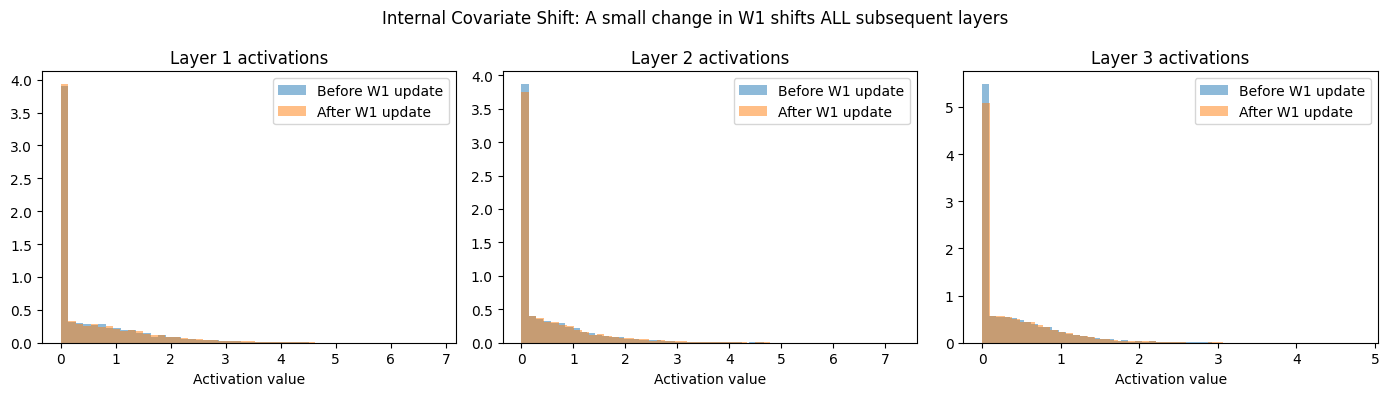

Layer 3 has to constantly adapt to these shifting inputs → slower, harder training


In [28]:
# Visualize the distribution shift
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for idx, (before, after, title) in enumerate([
    (h1_before, h1_after, 'Layer 1'),
    (h2_before, h2_after, 'Layer 2'),
    (h3_before, h3_after, 'Layer 3')
]):
    axes[idx].hist(before.flatten(), bins=50, alpha=0.5, label='Before W1 update', density=True)
    axes[idx].hist(after.flatten(), bins=50, alpha=0.5, label='After W1 update', density=True)
    axes[idx].set_title(f'{title} activations')
    axes[idx].legend()
    axes[idx].set_xlabel('Activation value')
    
plt.suptitle('Internal Covariate Shift: A small change in W1 shifts ALL subsequent layers', fontsize=12)
plt.tight_layout()
plt.show()

print("Layer 3 has to constantly adapt to these shifting inputs → slower, harder training")


## The Key Insight: Force the Distribution to Be Stable

What if, instead of hoping distributions stay stable, we **force** them to be stable?

The idea: After each layer, explicitly normalize the activations to have:
- **Mean = 0**
- **Variance = 1**

This is called **standardization**, a classic technique from statistics.


In [29]:
# The standardization formula is simple:
# x_normalized = (x - mean) / std

# Let's see it in action with a simple example
x = np.array([2.0, 4.0, 6.0, 8.0, 10.0])
print(f"Original:     {x}")
print(f"  mean = {x.mean():.2f}, std = {x.std():.2f}")

# Standardize
mean = x.mean()
std = x.std()
x_norm = (x - mean) / std

print(f"\nNormalized:   {x_norm}")
print(f"  mean = {x_norm.mean():.2f}, std = {x_norm.std():.2f}")
print("\n→ After normalization: mean=0, std=1 (guaranteed!)")


Original:     [ 2.  4.  6.  8. 10.]
  mean = 6.00, std = 2.83

Normalized:   [-1.41421356 -0.70710678  0.          0.70710678  1.41421356]
  mean = 0.00, std = 1.00

→ After normalization: mean=0, std=1 (guaranteed!)


In [30]:
# Let's break down what each step does

x = np.array([2.0, 4.0, 6.0, 8.0, 10.0])
mean = x.mean()
std = x.std()

print("Step by step:")
print(f"Original x:        {x}")
print(f"\n1. Compute mean:   μ = {mean}")
print(f"2. Subtract mean:  x - μ = {x - mean}")
print(f"   → Now centered around 0!")
print(f"\n3. Compute std:    σ = {std:.4f}")
print(f"4. Divide by std:  (x - μ) / σ = {(x - mean) / std}")
print(f"   → Now scaled to unit variance!")


Step by step:
Original x:        [ 2.  4.  6.  8. 10.]

1. Compute mean:   μ = 6.0
2. Subtract mean:  x - μ = [-4. -2.  0.  2.  4.]
   → Now centered around 0!

3. Compute std:    σ = 2.8284
4. Divide by std:  (x - μ) / σ = [-1.41421356 -0.70710678  0.          0.70710678  1.41421356]
   → Now scaled to unit variance!


### But Wait: Normalize Over WHICH Values?

In a neural network, we have tensors with multiple dimensions. For example, a batch of data might be:
- Shape: `(batch_size, features)` for fully-connected
- Shape: `(batch_size, channels, height, width)` for images
- Shape: `(batch_size, sequence_length, features)` for transformers

**The key question**: When computing mean and std, which dimensions do we average over?

Different choices lead to different normalization techniques!


In [31]:
# Let's create a toy example: batch of 4 samples, each with 3 features
# Think of this as 4 different inputs to a neural network

batch = np.array([
    [1.0, 2.0, 3.0],    # Sample 0
    [4.0, 5.0, 6.0],    # Sample 1
    [7.0, 8.0, 9.0],    # Sample 2
    [10.0, 11.0, 12.0], # Sample 3
])

print("Our batch of data:")
print("Shape: (batch_size=4, features=3)\n")
print("        Feature0  Feature1  Feature2")
for i, row in enumerate(batch):
    print(f"Sample {i}:  {row[0]:6.1f}    {row[1]:6.1f}    {row[2]:6.1f}")


Our batch of data:
Shape: (batch_size=4, features=3)

        Feature0  Feature1  Feature2
Sample 0:     1.0       2.0       3.0
Sample 1:     4.0       5.0       6.0
Sample 2:     7.0       8.0       9.0
Sample 3:    10.0      11.0      12.0


## Batch Normalization (2015)

The original and most influential: normalize **across the batch dimension**.

For each feature, compute the mean and std using all samples in the batch.


In [32]:
# Batch Normalization: normalize across the BATCH (axis=0)
# For each feature column, compute mean and std across all samples

print("Batch Normalization: normalize each FEATURE across all samples\n")
print("Original batch:")
print(batch)

# For each feature, compute mean across batch
batch_mean = batch.mean(axis=0)  # Shape: (3,) - one mean per feature
batch_std = batch.std(axis=0)    # Shape: (3,) - one std per feature

print(f"\nMean per feature (across batch): {batch_mean}")
print(f"Std per feature (across batch):  {batch_std}")

# Normalize
batch_normed = (batch - batch_mean) / (batch_std + 1e-5)

print(f"\nAfter Batch Normalization:")
print(batch_normed)
print(f"\nVerify: mean per feature = {batch_normed.mean(axis=0).round(4)}")
print(f"        std per feature  = {batch_normed.std(axis=0).round(4)}")


Batch Normalization: normalize each FEATURE across all samples

Original batch:
[[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]]

Mean per feature (across batch): [5.5 6.5 7.5]
Std per feature (across batch):  [3.35410197 3.35410197 3.35410197]

After Batch Normalization:
[[-1.34163679 -1.34163679 -1.34163679]
 [-0.44721226 -0.44721226 -0.44721226]
 [ 0.44721226  0.44721226  0.44721226]
 [ 1.34163679  1.34163679  1.34163679]]

Verify: mean per feature = [0. 0. 0.]
        std per feature  = [1. 1. 1.]


In [ ]:
# Visualize: which values are used to normalize each element?

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for feat_idx in range(3):
    ax = axes[feat_idx]
    
    # Show the batch as a heatmap
    im = ax.imshow(batch, cmap='Blues', aspect='auto')
    
    # Highlight the column being normalized
    for row in range(4):
        rect = plt.Rectangle((feat_idx-0.5, row-0.5), 1, 1, 
                             fill=False, edgecolor='red', linewidth=3)
        ax.add_patch(rect)
    
    # Add value labels
    for i in range(4):
        for j in range(3):
            ax.text(j, i, f'{batch[i,j]:.0f}', ha='center', va='center', fontsize=12)
    
    ax.set_xticks(range(3))
    ax.set_xticklabels(['F0', 'F1', 'F2'])
    ax.set_yticks(range(4))
    ax.set_yticklabels(['S0', 'S1', 'S2', 'S3'])
    ax.set_title(f'BatchNorm: Feature {feat_idx}\nμ={batch_mean[feat_idx]:.1f}, σ={batch_std[feat_idx]:.1f}')

plt.suptitle('Batch Norm: Each feature is normalized using values from ALL samples (red boxes)', fontsize=12)
plt.tight_layout()
plt.show()


### The Problem: Normalization Removes Useful Information!

Wait — if we always force mean=0 and std=1, we might lose expressiveness. 

What if the optimal representation for some feature IS to have mean=5 and std=2?

**Solution**: Add learnable parameters γ (scale) and β (shift):

$$\hat{x} = \gamma \cdot \frac{x - \mu}{\sigma} + \beta$$

The network can learn to "undo" the normalization if needed!


In [ ]:
# Demonstration: γ and β restore expressiveness

# After normalization (mean=0, std=1)
x_normalized = batch_normed[:, 0]  # Take feature 0
print(f"Normalized feature 0: mean={x_normalized.mean():.4f}, std={x_normalized.std():.4f}")

# Learnable parameters (initialized to γ=1, β=0, but can be learned)
gamma = 2.0  # Learned scale
beta = 5.0   # Learned shift

# Apply scale and shift
x_final = gamma * x_normalized + beta
print(f"\nAfter γ={gamma}, β={beta}: mean={x_final.mean():.4f}, std={x_final.std():.4f}")

print("\n→ The network can learn γ and β to get ANY mean and std it wants!")
print("→ If γ=σ_original and β=μ_original, we recover the original distribution")


### Problems with Batch Normalization

BatchNorm was revolutionary for CNNs, but has issues:

1. **Batch size dependency**: Statistics depend on other samples in the batch
   - Small batches → noisy estimates of mean/std → unstable training
   - Batch size 1 → can't compute statistics at all!

2. **Train/test mismatch**: During training we use batch statistics, but at test time we might have just one sample
   - Solution: Track "running mean/std" during training, use those at test time
   - But this creates a gap between train and test behavior

3. **Sequences are problematic**: For variable-length sequences, what's the "batch" for position 50 if some sequences are shorter?


In [ ]:
# Demonstrate: BatchNorm statistics are noisy with small batches
# "True" distribution we're sampling from
true_mean = 5.0
true_std = 2.0

# Sample batches of different sizes
batch_sizes = [2, 4, 8, 32, 128, 512]

print("Estimated mean and std for different batch sizes:\n")
print("Batch Size | Estimated μ | Estimated σ | Error in μ | Error in σ")
print("-" * 65)

for bs in batch_sizes:
    samples = np.random.randn(bs) * true_std + true_mean
    est_mean = samples.mean()
    est_std = samples.std()
    print(f"    {bs:>4}   |    {est_mean:>6.3f}   |    {est_std:>6.3f}   |   {abs(est_mean - true_mean):>6.3f}   |   {abs(est_std - true_std):>6.3f}")

print(f"\nTrue values: μ={true_mean}, σ={true_std}")
print("→ Small batches give noisy estimates!")


## Layer Normalization (2016): The Transformer Standard

**Key insight**: Instead of normalizing across the batch, normalize across the **features**.

Each sample is normalized independently using its own features — no dependency on batch size!


In [ ]:
# Layer Normalization: normalize across FEATURES (axis=1)
# For each sample, compute mean and std across all its features

print("Layer Normalization: normalize each SAMPLE across all its features\n")
print("Original batch:")
print(batch)

# For each sample, compute mean across features
layer_mean = batch.mean(axis=1, keepdims=True)  # Shape: (4, 1) - one mean per sample
layer_std = batch.std(axis=1, keepdims=True)    # Shape: (4, 1) - one std per sample

print(f"\nMean per sample (across features):")
for i, m in enumerate(layer_mean.flatten()):
    print(f"  Sample {i}: μ = {m:.2f}")

# Normalize
layer_normed = (batch - layer_mean) / (layer_std + 1e-5)

print(f"\nAfter Layer Normalization:")
print(layer_normed.round(4))
print(f"\nVerify: mean per SAMPLE = {layer_normed.mean(axis=1).round(4)}")
print(f"        std per SAMPLE  = {layer_normed.std(axis=1).round(4)}")


In [ ]:
# Visualize: BatchNorm vs LayerNorm - which values are grouped together?

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# BatchNorm: columns
ax = axes[0]
im = ax.imshow(batch, cmap='Blues', aspect='auto')
for i in range(4):
    for j in range(3):
        ax.text(j, i, f'{batch[i,j]:.0f}', ha='center', va='center', fontsize=14)

# Draw vertical boxes for columns
for col in range(3):
    rect = plt.Rectangle((col-0.5, -0.5), 1, 4, fill=False, 
                         edgecolor=['red', 'green', 'purple'][col], linewidth=3)
    ax.add_patch(rect)
ax.set_title('Batch Norm\nNormalize each COLUMN\n(across samples)', fontsize=12)
ax.set_xticks(range(3))
ax.set_xticklabels(['F0', 'F1', 'F2'])
ax.set_yticks(range(4))
ax.set_yticklabels(['S0', 'S1', 'S2', 'S3'])

# LayerNorm: rows
ax = axes[1]
im = ax.imshow(batch, cmap='Blues', aspect='auto')
for i in range(4):
    for j in range(3):
        ax.text(j, i, f'{batch[i,j]:.0f}', ha='center', va='center', fontsize=14)

# Draw horizontal boxes for rows
colors = ['red', 'green', 'purple', 'orange']
for row in range(4):
    rect = plt.Rectangle((-0.5, row-0.5), 3, 1, fill=False, 
                         edgecolor=colors[row], linewidth=3)
    ax.add_patch(rect)
ax.set_title('Layer Norm\nNormalize each ROW\n(across features)', fontsize=12)
ax.set_xticks(range(3))
ax.set_xticklabels(['F0', 'F1', 'F2'])
ax.set_yticks(range(4))
ax.set_yticklabels(['S0', 'S1', 'S2', 'S3'])

plt.suptitle('Batch Norm vs Layer Norm: Different normalization axes', fontsize=14)
plt.tight_layout()
plt.show()


### Why LayerNorm is Perfect for Transformers

1. **No batch dependency**: Each sample normalized independently
   - Works with batch size 1
   - Same behavior at train and test time

2. **Handles variable-length sequences**: Each token normalized using only its own features
   - No problem if sequences have different lengths

3. **Parallelizes well**: No communication needed across samples in a batch


## Other Normalizations: Instance Norm, Group Norm, GhostNorm

For completeness, here are other normalization variants (mainly used in vision):

- **Instance Norm**: Normalize each channel of each sample independently (great for style transfer)
- **Group Norm**: Split channels into groups, normalize each group (works with small batches)
- **GhostNorm**: Split batch into "ghost" sub-batches, helps stabilize BatchNorm

*(See the canonical picture in the article for a visual comparison of which dimensions each method normalizes over)*


## RMSNorm (2019): Simpler and Faster

A key observation: Do we really need to subtract the mean?

**RMSNorm** skips mean subtraction and just divides by the Root Mean Square:

$$\text{RMSNorm}(x) = \frac{x}{\text{RMS}(x)} \cdot \gamma \quad \text{where} \quad \text{RMS}(x) = \sqrt{\frac{1}{n}\sum_i x_i^2}$$

Why does this work? The re-centering (mean subtraction) turns out to be less important than the re-scaling!


In [ ]:
# Compare LayerNorm vs RMSNorm

def layer_norm(x, eps=1e-5):
    mean = x.mean(axis=-1, keepdims=True)
    std = x.std(axis=-1, keepdims=True)
    return (x - mean) / (std + eps)

def rms_norm(x, eps=1e-5):
    rms = np.sqrt((x ** 2).mean(axis=-1, keepdims=True))
    return x / (rms + eps)

# Test on our batch
print("Original batch:")
print(batch)

print("\nLayerNorm (subtract mean, divide by std):")
print(layer_norm(batch).round(4))

print("\nRMSNorm (just divide by RMS, no mean subtraction):")
print(rms_norm(batch).round(4))

print("\n→ RMSNorm is simpler (no mean computation) and often works just as well!")
print("→ Used in LLaMA, Gemma, and other modern LLMs")


## Pre-Norm vs Post-Norm: Where to Put the Normalization?

The original Transformer (2017) used **Post-Norm**:
```
x → Attention → Add(x) → LayerNorm → FFN → Add → LayerNorm
```

Modern transformers use **Pre-Norm**:
```
x → LayerNorm → Attention → Add(x) → LayerNorm → FFN → Add
```

Why the change?


In [ ]:
# Let's trace the gradient flow in both architectures

# Post-Norm: x → f(x) → x + f(x) → LayerNorm(x + f(x))
# The gradient flows: dL/dx = dL/d(norm_out) * d(norm_out)/d(x+f(x)) * (1 + df/dx)
# The normalization is AFTER the residual, so gradients must flow THROUGH the normalization

# Pre-Norm: x → LayerNorm(x) → f(LayerNorm(x)) → x + f(LayerNorm(x))
# The gradient flows: dL/dx = dL/d(out) * (1 + df/d(norm(x)) * d(norm)/dx)
# The residual connection provides a DIRECT path that bypasses normalization!

print("Post-Norm gradient path:")
print("  Gradient must flow THROUGH LayerNorm to reach earlier layers")
print("  → LayerNorm can attenuate/distort gradients")
print("  → Harder to train very deep networks")

print("\nPre-Norm gradient path:")
print("  Residual connection provides DIRECT gradient highway")
print("  x_out = x + f(LayerNorm(x))")
print("  ∂x_out/∂x = 1 + ∂f/∂x  ← The '1' is a direct gradient path!")
print("  → Gradients flow easily regardless of depth")
print("  → Much more stable training")


In [ ]:
# Simulate gradient magnitude through many layers

def simulate_gradient_post_norm(num_layers, norm_scale=0.9):
    """Post-norm: gradient must pass through norm at each layer"""
    grad = 1.0
    grads = [grad]
    for _ in range(num_layers):
        # Gradient passes through: residual branch + normalization
        grad = grad * norm_scale  # Normalization can shrink gradients
        grads.append(grad)
    return grads

def simulate_gradient_pre_norm(num_layers, norm_scale=0.9):
    """Pre-norm: residual provides direct path"""
    grad = 1.0
    grads = [grad]
    for _ in range(num_layers):
        # Gradient has direct path (1) plus path through f (attenuated)
        grad = grad * 1.0  # Direct residual path preserves gradient!
        grads.append(grad)
    return grads

num_layers = 50
post_grads = simulate_gradient_post_norm(num_layers)
pre_grads = simulate_gradient_pre_norm(num_layers)

fig, ax = plt.subplots(figsize=(12, 5))
ax.semilogy(post_grads, 'o-', label='Post-Norm (gradient through norm)', markersize=3)
ax.semilogy(pre_grads, 's-', label='Pre-Norm (direct residual path)', markersize=3)
ax.set_xlabel('Layer (from output to input)')
ax.set_ylabel('Gradient magnitude')
ax.set_title('Gradient flow: Pre-Norm vs Post-Norm')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

print("→ Pre-Norm maintains gradient magnitude through many layers!")
print("→ This is why modern transformers (GPT, LLaMA, etc.) use Pre-Norm")


## A Brief History of Normalization

| Year | Technique | Key Idea | Main Use Case |
|------|-----------|----------|---------------|
| 2015 | **Batch Normalization** | Normalize across batch | CNNs, large batch training |
| 2016 | **Layer Normalization** | Normalize across features | RNNs, Transformers |
| 2016 | **Instance Normalization** | Normalize per sample, per channel | Style transfer |
| 2018 | **Group Normalization** | Normalize groups of channels | Small batch CNNs |
| 2019 | **RMSNorm** | Skip mean, just scale by RMS | Efficient transformers |
| 2022 | **DeepNorm** | Modified LayerNorm for very deep nets | Deep transformers |

Each was invented to solve a specific problem with the previous approaches. Let's see why!


## Modern Variants for Very Deep Networks

### QK-LayerNorm

Apply LayerNorm specifically to the Query and Key vectors in attention:
```
Q = LayerNorm(W_q @ x)
K = LayerNorm(W_k @ x)
```

This prevents the dot product Q·K from exploding, which is especially important for long sequences.

### DeepNorm (2022)

For very deep transformers (1000+ layers), even Pre-Norm can have issues. DeepNorm modifies the residual connection:
```
x_out = LayerNorm(α * x + f(x))
```

The α factor (typically > 1) scales up the residual, helping gradients flow even better.


## Advanced: The Linear Folding Trick

Here's a subtle but powerful insight: The scale (γ) and shift (β) in LayerNorm are just a linear transformation!

$$\text{output} = \gamma \odot \hat{x} + \beta$$

And LayerNorm is always applied immediately BEFORE another linear layer (MLP, Q/K/V projections, unembedding). Since linear ∘ linear = linear, we can **fold** the γ and β into the next linear layer's weights!


In [ ]:
# Demonstration: Folding LayerNorm's γ and β into the next linear layer

# Original: LayerNorm(x) → Linear
# LayerNorm output: y = γ * x_normalized + β
# Linear output: z = W @ y + b = W @ (γ * x_norm + β) + b
#              = (W * γ) @ x_norm + (W @ β + b)
#              = W_effective @ x_norm + b_effective

# So we can create an "effective" linear layer that absorbs γ and β!

d_in, d_out = 4, 3
torch.manual_seed(42)

# Original LayerNorm parameters
gamma = torch.tensor([1.5, 0.8, 1.2, 0.9])  # scale
beta = torch.tensor([0.1, -0.2, 0.0, 0.3])  # shift

# Original linear layer
W = torch.randn(d_out, d_in)
b = torch.randn(d_out)

# Fold γ and β into effective weights
W_effective = W * gamma  # Each column of W scaled by corresponding γ
b_effective = W @ beta + b  # Bias absorbs the β contribution

print("Original W shape:", W.shape)
print("W_effective shape:", W_effective.shape)

# Verify: both approaches give same result
x_normalized = torch.randn(2, d_in)  # Pretend this is the normalized input

# Approach 1: Apply γ, β, then linear
y1 = gamma * x_normalized + beta
z1 = x_normalized @ W.T + b

# Approach 2: Use folded weights directly on normalized input
z2 = x_normalized @ W_effective.T + b_effective

print(f"\nWith γ,β then linear: {(W @ (gamma * x_normalized[0] + beta) + b).detach().numpy().round(4)}")
print(f"With folded weights:  {(W_effective @ x_normalized[0] + b_effective).detach().numpy().round(4)}")
print("\n→ Same result! Libraries like TransformerLens use fold_ln=True for this")


## Interpretability: LayerNorm is "Almost Linear"

LayerNorm would be perfectly linear if not for dividing by the variance:

$$\text{LayerNorm}(x) = \gamma \odot \frac{x - \mu}{\sqrt{\text{Var}[x] + \epsilon}} + \beta$$

The subtraction of mean is linear. The multiplication by γ and addition of β are linear. But dividing by $\sqrt{\text{Var}[x]}$ is **not** linear — it depends on the input itself!

**The key insight for interpretability**: If you're making a SMALL change to x, the variance barely changes, so you can treat it as a constant. This makes LayerNorm approximately linear for small perturbations.


In [ ]:
# Demonstration: LayerNorm is approximately linear for small changes

def layer_norm_simple(x, eps=1e-5):
    mean = x.mean()
    std = x.std()
    return (x - mean) / (std + eps)

x = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
original_norm = np.sqrt((x**2).sum())

print("Testing linearity of LayerNorm:\n")

# Small perturbation
delta_small = np.array([0.01, -0.02, 0.015, -0.01, 0.005])
x_perturbed_small = x + delta_small

# Large perturbation
delta_large = np.array([2.0, -3.0, 1.5, -2.5, 4.0])
x_perturbed_large = x + delta_large

# If LayerNorm were linear: LN(x + δ) = LN(x) + LN(δ) - LN(0)
# More practically: LN(x + δ) ≈ LN(x) + J @ δ where J is the Jacobian

ln_x = layer_norm_simple(x)
ln_small = layer_norm_simple(x_perturbed_small)
ln_large = layer_norm_simple(x_perturbed_large)

# Check how much the variance changed
var_original = x.var()
var_small = x_perturbed_small.var()
var_large = x_perturbed_large.var()

print(f"Original variance: {var_original:.4f}")
print(f"After small δ:     {var_small:.4f} (change: {abs(var_small - var_original)/var_original*100:.2f}%)")
print(f"After large δ:     {var_large:.4f} (change: {abs(var_large - var_original)/var_original*100:.2f}%)")

print(f"\n→ Small perturbations barely change the variance")
print(f"→ So we can treat √Var as constant → LayerNorm becomes linear!")
print(f"→ This is useful for mechanistic interpretability research")


## DeepNorm in Practice: GLM and 1000-Layer Transformers

**DeepNorm** (Microsoft, 2022) enabled training transformers with 1000+ layers. The key modifications:

1. **Scale up residuals**: $x_{out} = \text{LayerNorm}(\alpha \cdot x + f(x))$ where α > 1
2. **Scale down initialization**: Initialize sublayer weights smaller by factor β

The α and β values depend on the number of layers:
- For N encoder layers: α = $(2N)^{1/4}$, β = $(8N)^{-1/4}$  
- For N decoder layers: α = $(3N)^{1/4}$, β = $(12N)^{-1/4}$

**GLM (General Language Model)** and **ChatGLM** use DeepNorm to stabilize training of their very deep architectures.


In [ ]:
# DeepNorm implementation

class DeepNormResidual(nn.Module):
    """DeepNorm: scaled residual for very deep networks"""
    def __init__(self, dim, num_layers, is_decoder=True):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        
        # Compute α based on depth
        if is_decoder:
            self.alpha = (3 * num_layers) ** 0.25
        else:
            self.alpha = (2 * num_layers) ** 0.25
    
    def forward(self, x, sublayer_output):
        # DeepNorm: LayerNorm(α * x + sublayer_output)
        return self.norm(self.alpha * x + sublayer_output)

# Compare scaling factors for different depths
print("DeepNorm α values for different depths (decoder):\n")
for n_layers in [6, 12, 24, 48, 96, 1000]:
    alpha = (3 * n_layers) ** 0.25
    beta = (12 * n_layers) ** -0.25
    print(f"  {n_layers:4d} layers: α = {alpha:.3f}, β = {beta:.4f}")

print("\n→ More layers = larger α (stronger residual) and smaller β (smaller init)")
print("→ This prevents gradient explosion even with 1000+ layers")


## Modern Convergence: RMSNorm + Pre-Norm

The LLM community has largely converged on a standard recipe:

| Model Family           | Normalization | Placement        | Notes                                               |
|------------------------|---------------|------------------|-----------------------------------------------------|
| GPT-2 / GPT-3 / GPT-4  | LayerNorm     | Pre-Norm         | Classic OpenAI lineage                              |
| PaLM / Chinchilla      | LayerNorm     | Pre-Norm         | Google/DeepMind lineage                             |
| LLaMA (1/2/3)          | RMSNorm       | Pre-Norm         | Modern open-source default                          |
| Mistral (7B / larger)  | RMSNorm       | Pre-Norm         | LLaMA-style stack                                   |
| Gemma (Google)         | RMSNorm       | Mixed (Pre + Post) | RMSNorm around both attention & FFN in some blocks |
| GLM-130B / GLM line    | DeepNorm-style| Modified Pre/Post | Residual-scaled DeepNorm variant                    |

**Why RMSNorm won:**
1. **Simpler**: No mean computation needed
2. **Faster**: ~7-10% speedup from skipping mean subtraction
3. **Works just as well**: Empirically matches LayerNorm performance
4. **Better for parallelization**: One less reduction operation

The mean subtraction in LayerNorm turned out to be mostly unnecessary — the re-scaling is what matters!


In [ ]:
# Performance comparison: LayerNorm vs RMSNorm
import time

def benchmark(fn, x, num_iters=1000):
    # Warmup
    for _ in range(100):
        _ = fn(x)
    
    start = time.time()
    for _ in range(num_iters):
        _ = fn(x)
    return (time.time() - start) / num_iters * 1000  # ms

# Create test data
x_test = torch.randn(32, 512, 768)  # Typical transformer shape

# Compare
ln = nn.LayerNorm(768)
rms = RMSNorm(768)

# Benchmark
ln_time = benchmark(ln, x_test)
rms_time = benchmark(rms, x_test)

print(f"LayerNorm: {ln_time:.4f} ms")
print(f"RMSNorm:   {rms_time:.4f} ms")
print(f"Speedup:   {ln_time/rms_time:.2f}x")
print("\n→ RMSNorm is faster because it skips the mean computation!")


## Complete PyTorch Implementations


In [ ]:
class LayerNorm(nn.Module):
    """Standard Layer Normalization"""
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))
    
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


class RMSNorm(nn.Module):
    """Root Mean Square Normalization (no mean subtraction)"""
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(dim))
    
    def forward(self, x):
        rms = torch.sqrt((x ** 2).mean(dim=-1, keepdim=True) + self.eps)
        return self.gamma * x / rms


# Test both
x = torch.randn(2, 4, 8)  # (batch, seq, features)

ln = LayerNorm(8)
rms = RMSNorm(8)

print("Input shape:", x.shape)
print("LayerNorm output shape:", ln(x).shape)
print("RMSNorm output shape:", rms(x).shape)

# Verify normalization
ln_out = ln(x)
print(f"\nLayerNorm output - mean: {ln_out.mean(dim=-1).mean():.6f}, std: {ln_out.std(dim=-1).mean():.4f}")


## Summary

| Situation | Recommended Norm | Why |
|-----------|-----------------|-----|
| CNNs with large batches | **BatchNorm** | Fast, works great with big batches |
| CNNs with small batches | **GroupNorm** | Doesn't depend on batch size |
| Transformers / LLMs | **RMSNorm** or **LayerNorm** (modern) | Simpler, faster, Pre-Norm position |
| Style transfer | **InstanceNorm** | Normalizes style per-image |
| Very deep (1000+ layers) | **DeepNorm** | Scaled residuals for extreme depth (experimental) |
| Long-context attention | **QK-LayerNorm** | Prevents attention score explosion (experimental) |

**The key intuitions:**
1. Normalization keeps activations stable → enables training deep networks
2. Initialization helps at the start, but distributions drift during training
3. Different normalization axes (batch vs features) suit different architectures
4. **Pre-Norm is more stable** than Post-Norm for gradient flow
5. **RMSNorm + Pre-Norm** is the modern standard (LLaMA, Mistral, Gemma) but Layernorm is still used often
6. γ and β can be **folded into the next linear layer** for efficiency
7. LayerNorm is **"almost linear"** for small perturbations (useful for interpretability)
